In [28]:
%reload_ext autoreload
%autoreload 2

In [29]:
import sys
sys.path.append('../..')

In [30]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [31]:
import os
from pathlib import Path

data_root = Path('../../data_/FAUST_r')
n_eig = 200
no_eig = False
no_dist = False
no_normalize = True

assert n_eig > 0, f'invalid n_eig: {n_eig}'
assert os.path.isdir(data_root), f'invalid data root: {data_root}'

## Folder structure

In [32]:
if not no_eig:
    npz_dir = data_root / 'npz'
    os.makedirs(npz_dir, exist_ok=True)

if not no_dist:
    dist_dir = data_root / 'dist'
    os.makedirs(dist_dir, exist_ok=True)

In [33]:
from glob import glob

off_files = sorted(glob(str(data_root / 'off' / '*.off')))
assert len(off_files) != 0

off_file = off_files[0]
off_file

'../../data_/FAUST_r/off/tr_reg_000.off'

In [55]:
import numpy as np
import open3d as o3d
import time
start_time = time.time()

for _ in range(100):
    mesh = o3d.io.read_triangle_mesh(off_file)
    verts, faces = np.asarray(mesh.vertices), np.asarray(mesh.triangles)
end_time = time.time()
f'{100 / (end_time - start_time):.2f} read/s'

'143.79 read/s'

In [35]:
verts.shape, faces.shape

((4999, 3), (9994, 3))

## LBO

In [36]:
import torch
from src.utils.geometry import compute_operators

frames, mass_vec, L, evals, evecs, gradX, gradY = compute_operators(
    torch.from_numpy(verts).float(),
    torch.from_numpy(faces).long(),
    k=n_eig,
)

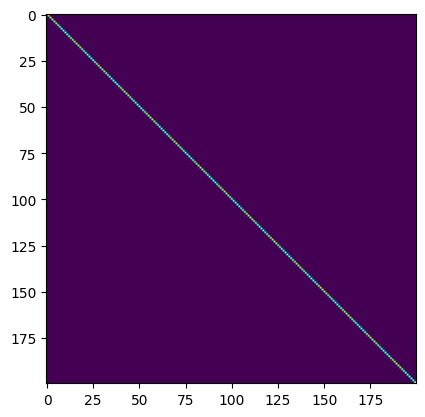

In [37]:
import matplotlib.pyplot as plt
plt.imshow(evecs.T @ torch.diag(mass_vec) @ evecs)
plt.show()

In [38]:
from src.utils.geometry import torch2np, sparse_torch_to_np

frames_np = torch2np(frames).astype(np.float32)
mass_np = torch2np(mass_vec).astype(np.float32)
evals_np = torch2np(evals).astype(np.float32)
evecs_np = torch2np(evecs).astype(np.float32)
L_np = sparse_torch_to_np(L).astype(np.float32)
gradX_np = sparse_torch_to_np(gradX).astype(np.float32)
gradY_np = sparse_torch_to_np(gradY).astype(np.float32)

np.savez(
    npz_dir / f'{Path(off_file).stem}.npz',
    verts=verts,
    faces=faces,
    k_eig=n_eig,
    frames=frames_np,
    mass=mass_np,
    evals=evals_np,
    evecs=evecs_np,
    L_data=L_np.data,
    L_indices=L_np.indices,
    L_indptr=L_np.indptr,
    L_shape=L_np.shape,
    gradX_data=gradX_np.data,
    gradX_indices=gradX_np.indices,
    gradX_indptr=gradX_np.indptr,
    gradX_shape=gradX_np.shape,
    gradY_data=gradY_np.data,
    gradY_indices=gradY_np.indices,
    gradY_indptr=gradY_np.indptr,
    gradY_shape=gradY_np.shape,
)

In [39]:
import time
start_time = time.time()

for _ in range(100):
    np.load(
        npz_dir / f'{Path(off_file).stem}.npz'
    )

end_time = time.time()
f'{100 / (end_time - start_time):.2f} read/s'

'15100.46 read/s'

## Geodist

In [40]:
import scipy.io as sio
from src.utils.shape import compute_geodesic_distmat

dist_mat = compute_geodesic_distmat(verts, faces)

In [ ]:
import time
start_time = time.time()

for _ in range(100):
    corr = np.loadtxt(
        data_root / 'corres' / f'{Path(off_file).stem}.vts',
        dtype=np.int32,
    ) - 1  # minus 1 to start from 0

end_time = time.time()
f'{100 / (end_time - start_time):.2f} read/s'

array([4414, 1129, 1929, ..., 3617,  173, 2482], dtype=int32)

In [47]:
np.savez(
    dist_dir / f'{Path(off_file).stem}.npz',
    dist_mat=dist_mat,
    corr=corr,
)

In [49]:
import time
start_time = time.time()

for _ in range(100):
    np.load(
        dist_dir / f'{Path(off_file).stem}.npz'
    )
    
end_time = time.time()
f'{100 / (end_time - start_time):.2f} read/s'

'34258.79 read/s'

In [53]:
import time
start_time = time.time()

for _ in range(100):
    mat = sio.loadmat('../../data/FAUST_r/dist/tr_reg_000.mat')

end_time = time.time()
f'{100 / (end_time - start_time):.2f} read/s'

'15.26 read/s'